In [1]:
# --------------------------------------
# Teslakit database


# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator



p_data = r'/home/nicolas/Projects/TESLAKIT/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')






In [2]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
print(WVS)
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])

<xarray.Dataset>
Dimensions:      (time: 111040)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2016-12-31T21:00:00
Data variables:
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    TC_category  (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1


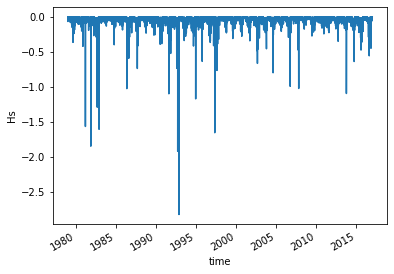

In [9]:
from teslakit.waves import Aggregate_WavesFamilies

# Misterio resuelto:
# hay dos variables Hs, Tp, Dir por error
# 1- una viene con los datos input de oleaje (vienen las familias y ya agregados)
# 2- el otro Hs, Tp, Dir sale de agregar con nuestra formula, ya sea cuadrática o tp máx energy

# ------ > No son exactamente los mismos valores < ------


# Error encontrado:
# con el 1 calculaba AWL y máximos por tormenta para el ajuste del emulador climático
# mientras que todo teslakit usa el 2


# Historical gow waves point     <-- CLIMATE EMULATOR SE AJUSTA CON ESTA HS Y TP, que viene guardada en el input
WVS = db.Load_WAVES_hist()   

# Agregamos las familias         <-- ABSOLUTAMENTE TODO EL RESTO DEL CODIGO USA LA HS Y TP DE AGREGAR
wa = Aggregate_WavesFamilies(WVS)


# ploteo la diferencia entre Hs y Hs_agregada
D = wa.Hs-WVS.Hs
D.plot()

In [14]:
print(WVS.Hs.values[:])

[3.31571 3.45728 3.38221 ... 2.10452 2.11363 2.1952 ]


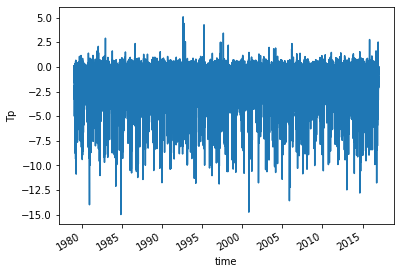

In [10]:
# ploteo la diferencia entre Tp y Tp_agregado
T = wa.Tp-WVS.Tp
T.plot()

In [ ]:
# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time limits
WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

CE.FitExtremes(DWTs_fit, WVS_fit, config)